# Imports

In [80]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from keras.models import Sequential
from keras import layers # Dense, LSTM
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

In [81]:
kaggle_ds = pd.read_csv("data/kaggle_dataset.csv")
mac_ds = pd.read_csv("data/merged_and_cleaned.csv")
mac_rm_ds = pd.read_csv("data/merged_and_cleaned_rm.csv")

# First dataset

In [82]:
def tweet_tokenizer(text):
  text = re.sub(r'http\S+', '', text)
  tt = TweetTokenizer(reduce_len=True, strip_handles=True)
  return tt.tokenize(text)

class LemmaTokenizer(object):
  def __init__(self):
      self.wnl = WordNetLemmatizer()
  def __call__(self, articles):
      return [self.wnl.lemmatize(t) for t in tweet_tokenizer(articles)]

In [83]:
X, y = kaggle_ds["Text"], kaggle_ds["Emotion"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [84]:
stopwords = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stopwords, tokenizer=LemmaTokenizer())

In [85]:
X_matrix_train = vectorizer.fit_transform(X_train).toarray()
X_matrix_test = vectorizer.transform(X_test).toarray()

/Users/rom1/opt/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


In [86]:
input_dim = X_matrix_train.shape[1]
output_dim = len(kaggle_ds["Emotion"].unique())

# Je définis l'architecture de mon réseau de neurones
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))

# Classification multinomial donc soft max et 4 classes à prédire donc 4 neuones
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax')) # error when using the "output_dim" variable

In [87]:
model.compile("nadam", "sparse_categorical_crossentropy", ["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 10)                148170    
                                                                 
 dense_17 (Dense)            (None, 10)                110       
                                                                 
 dense_18 (Dense)            (None, 10)                110       
                                                                 
 dense_19 (Dense)            (None, 6)                 66        
                                                                 
Total params: 148,456
Trainable params: 148,456
Non-trainable params: 0
_________________________________________________________________


In [88]:
# mlb = MultiLabelBinarizer(classes=y_train.unique())
# y_matrix_train = mlb.fit_transform(y_train)
# y_matrix_test = mlb.transform(y_test)

lbe = LabelEncoder()
y_matrix_train = lbe.fit_transform(y_train)
y_matrix_test = lbe.transform(y_test)

In [89]:
lbe.classes_

array(['anger', 'fear', 'happy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [90]:
y_matrix_train

array([3, 2, 2, ..., 0, 2, 2])

In [91]:
earlyStopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [92]:
history = model.fit(X_matrix_train, y_matrix_train, validation_data=(X_matrix_test, y_matrix_test), epochs=30, batch_size=32)

Epoch 1/30
503/503 [==============================] - 6s 10ms/step - loss: 1.1871 - accuracy: 0.5677 - val_loss: 0.7389 - val_accuracy: 0.7441
Epoch 2/30
503/503 [==============================] - 5s 10ms/step - loss: 0.4597 - accuracy: 0.8459 - val_loss: 0.4879 - val_accuracy: 0.8347
Epoch 3/30
503/503 [==============================] - 5s 10ms/step - loss: 0.2187 - accuracy: 0.9293 - val_loss: 0.4790 - val_accuracy: 0.8466
Epoch 4/30
503/503 [==============================] - 4s 8ms/step - loss: 0.1288 - accuracy: 0.9656 - val_loss: 0.5030 - val_accuracy: 0.8531
Epoch 5/30
503/503 [==============================] - 5s 9ms/step - loss: 0.0803 - accuracy: 0.9786 - val_loss: 0.5624 - val_accuracy: 0.8496
Epoch 6/30
503/503 [==============================] - 5s 9ms/step - loss: 0.0590 - accuracy: 0.9827 - val_loss: 0.6053 - val_accuracy: 0.8455
Epoch 7/30
503/503 [==============================] - 4s 9ms/step - loss: 0.0424 - accuracy: 0.9874 - val_loss: 0.6656 - val_accuracy: 0.8459
Epo

In [93]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

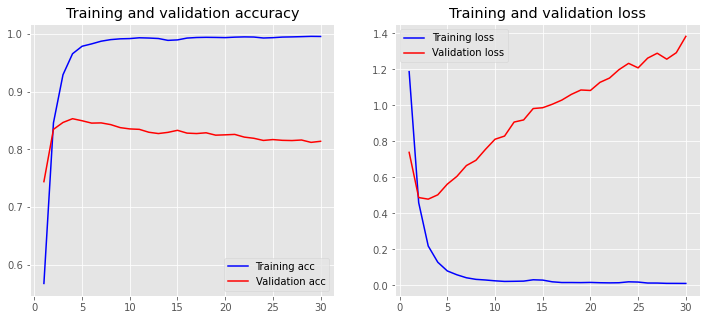

In [94]:
plot_history(history)

In [95]:
score = model.evaluate(X_matrix_test, y_matrix_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.383216142654419
Test accuracy: 0.8139795064926147
